In [1]:
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity as cs

from wordcloud import WordCloud

import warnings

In [2]:
# !pip install --upgrade numpy==1.23.5
import numpy as np
print(np.__version__)

1.23.5


In [3]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_stopwords = default_stopwords + ['said', 'would','even','according','could','year',
                                         'years','also','new','people','old,''one','two','time',
                                         'first','last','say','make','best','get','three','make',
                                         'year old','told','made','like','take','many','set','number',
                                         'month','week','well','back']
shortword = re.compile(r'\W*\b\w{1,4}\b\d')
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
def clean_text(text, ):

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w)>=3]

    def preprocessing_text(text):
        text = text.lower()
        text=text.replace('\n',' ').replace('\xa0',' ').replace('-',' ').replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text=re.sub(r'\d+','', text)
        text=re.sub(r'http\S+', '', text)
        text=BAD_SYMBOLS_RE.sub(' ', text)
        text=REPLACE_IP_ADDRESS.sub('', text)
        text=REPLACE_BY_SPACE_RE.sub(' ', text)
        text=' '.join(word for word in text.split() if len(word)>3)
        
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ') # strip whitespaces
    text = text.lower() # lowercase
    #text = stem_text(text) # stemming
    text=preprocessing_text(text)
    text = remove_special_characters(text) # remove punctuation and symbols
    text = lemm_text(text) # lemmatizer
    text = remove_stopwords(text) # remove stopwords

    return text

In [4]:
df = pd.read_csv('combined_news_data.csv')

In [5]:
df = df[df['category_level_1'].isin(['sport', 'science and technology', 'economy, business and finance', 'arts, culture, entertainment and media','politics', ])]

In [6]:
df['text']= df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)),axis=1)

In [7]:
df['text'] = df['text'].apply(clean_text)

In [8]:
def encode_labels(y):
    le = LabelEncoder()
    return le.fit_transform(y)

In [9]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
layer = TFDistilBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['dropout_19', 'pre_classifier', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [11]:
def regular_encode(texts, tokenizer,  maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        truncation=True,
        return_attention_mask=False, 
        return_token_type_ids=False,
        padding=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [12]:
# def build_model(transformer, y_shape, loss='categorical_crossentropy', max_len=512):
#     input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
#     sequence_output = transformer(input_word_ids)[0]
#     cls_token = sequence_output[:, 0, :]
#     #adding dropout layer
    
#     x = tf.keras.layers.Dropout(0.3)(cls_token)

#     #using a dense layer of category size neurons. 
#     out = tf.keras.layers.Dense(y_shape, activation='sigmoid')(x)
#     model = tf.keras.Model(inputs=input_word_ids, outputs=out)

#     #using categorical crossentropy as the loss as it is a multi-class classification problem
#     model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5), loss=loss, metrics=['accuracy'])
#     return model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
def build_model(transformer, y_shape, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    # Adding dropout layer after the transformer output
    x = tf.keras.layers.Dropout(0.5)(cls_token)
    
    # Adding additional dense layers
    # x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    out = tf.keras.layers.Dense(y_shape, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    
    # Compile with a lower learning rate
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss, metrics=['accuracy'])
    
    return model


With CrossValidation

In [15]:
from sklearn.model_selection import KFold
import numpy as np

def train_dist_bert_kfold(X, y, model_save_path, n_splits=5):
    
    y_lr = encode_labels(y)

    # Converting the categories into one-hot vectors using tf.keras.utils.to_categorical
    y_cat = tf.keras.utils.to_categorical(y_lr, dtype='int32')
    
    # KFold Cross Validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_no = 1
    all_scores = []
    
    for train_index, test_index in kfold.split(X):
        print(f'Training fold {fold_no}...')
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_cat[train_index], y_cat[test_index]
        
        # Building the model for each fold
        model = build_model(layer, max_len=80, y_shape=y_cat.shape[1])
        
        # Creating the training and testing datasets
        BATCH_SIZE = 16
        AUTO = tf.data.experimental.AUTOTUNE
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X_train, y_train))
            .shuffle(2048)
            .batch(BATCH_SIZE)
            .repeat()
            .prefetch(AUTO)
        )
        test_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X_test, y_test))
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )

        validation_steps = (X_test.shape[0] // BATCH_SIZE)
        print(X_test.shape[0])

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        # Training the model for the current fold
        # n_steps = X_train.shape[0] // BATCH_SIZE
        steps_per_epoch = (len(X_train) // BATCH_SIZE)-1
        train_history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=10,
            validation_steps=validation_steps,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping]
        )
        
        # Plot training & validation accuracy/loss for each fold
        plt.figure(figsize=(10, 6))
        plt.plot(train_history.history['accuracy'], label=f'Training Accuracy Fold {fold_no}', color='tab:green')
        plt.plot(train_history.history['val_accuracy'], label=f'Validation Accuracy Fold {fold_no}', color='tab:olive', linestyle='--')
        plt.title(f'Training and Validation Accuracy for Fold {fold_no}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_history.history['loss'], label=f'Training Loss Fold {fold_no}', color='tab:blue')
        plt.plot(train_history.history['val_loss'], label=f'Validation Loss Fold {fold_no}', color='tab:cyan', linestyle='--')
        plt.title(f'Training and Validation Loss for Fold {fold_no}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Making predictions
        preds = model.predict(test_dataset, verbose=1)
        pred_classes = np.argmax(preds, axis=1)
        
        print(f'Fold {fold_no} Precision: {precision_score(np.argmax(y_test, axis=1), pred_classes, average="macro")}')
        print(f'Fold {fold_no} Recall: {recall_score(np.argmax(y_test, axis=1), pred_classes, average="macro")}')
        print(f'Fold {fold_no} F1: {f1_score(np.argmax(y_test, axis=1), pred_classes, average="macro")}')
        
        # Print classification report
        print(f"\nFold {fold_no} Classification Report:\n", classification_report(np.argmax(y_test, axis=1), pred_classes))
        
        # Save model for the current fold
        model.save(f'{model_save_path}_fold_{fold_no}.h5')

        # Append validation accuracy for the current fold
        all_scores.append(train_history.history['val_accuracy'][-1])
        
        fold_no += 1

    # Calculate the mean validation accuracy across all folds
    print(f'\nAverage Validation Accuracy across {n_splits} folds: {np.mean(all_scores)}')



In [16]:
def train_dist_bert(X, y, model_save_path):
    
    # y_lr = encode_labels(y)
    le = LabelEncoder()
    y_lr =  le.fit_transform(y)

    #converting the categories into one hot vectors using tf.keras.utils.to_categorical
    y_cat = tf.keras.utils.to_categorical(y_lr, dtype = 'int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, random_state = 42, test_size = 0.2)
    
    #building the model
    model = build_model(layer, max_len=80, y_shape=y_cat.shape[1])
    
    #creating the training and testing dataset.
    BATCH_SIZE = 32
    AUTO = tf.data.experimental.AUTOTUNE 
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(X_test)
        .batch(BATCH_SIZE)
    )
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    #training for 10 epochs
    n_steps = X_train.shape[0] // BATCH_SIZE
    train_history = model.fit(
        train_dataset,
        steps_per_epoch=n_steps,
        epochs=20,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_history.history['accuracy'], label='Training Accuracy', color='tab:green')
    plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy', color='tab:olive', linestyle='--')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_history.history['loss'], label='Training Loss', color='tab:blue')
    plt.plot(train_history.history['val_loss'], label='Validation Loss', color='tab:cyan', linestyle='--')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #making predictions
    preds = model.predict(test_dataset,verbose = 1)
    #converting the one hot vector output to a linear numpy array.
    pred_classes = np.argmax(preds, axis = 1)
    
    print('Precision is {}'.format(precision_score(np.argmax(y_test, axis=1), pred_classes, average='macro')))
    print('Recall is {}'.format(recall_score(np.argmax(y_test, axis=1), pred_classes, average='macro')))
    print('F1:', f1_score(np.argmax(y_test, axis=1), pred_classes, average='macro'))


    # Print classification report
    print("\nClassification Report:\n", classification_report(np.argmax(y_test, axis=1), pred_classes))

    cm = confusion_matrix(np.argmax(y_test, axis=1), pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    model.save(model_save_path)

In [17]:
X_encoded = regular_encode(df['text'].astype('str'), tokenizer, maxlen=80)

Epoch 1/20
209/209 [==============================] - 54s 206ms/step - loss: 4.2091 - accuracy: 0.5612 - val_loss: 3.5846 - val_accuracy: 0.7856
Epoch 2/20
209/209 [==============================] - 42s 203ms/step - loss: 3.4566 - accuracy: 0.8150 - val_loss: 3.2340 - val_accuracy: 0.8571
Epoch 3/20
209/209 [==============================] - 37s 175ms/step - loss: 3.0563 - accuracy: 0.8889 - val_loss: 3.1221 - val_accuracy: 0.8600
Epoch 4/20
209/209 [==============================] - 37s 175ms/step - loss: 2.7858 - accuracy: 0.9112 - val_loss: 2.8852 - val_accuracy: 0.8440
Epoch 5/20
209/209 [==============================] - 37s 177ms/step - loss: 2.5054 - accuracy: 0.9306 - val_loss: 2.6635 - val_accuracy: 0.8630
Epoch 6/20
209/209 [==============================] - 37s 179ms/step - loss: 2.2256 - accuracy: 0.9541 - val_loss: 2.4751 - val_accuracy: 0.8636
Epoch 7/20
209/209 [==============================] - 38s 180ms/step - loss: 1.9738 - accuracy: 0.9613 - val_loss: 2.2413 - val_ac

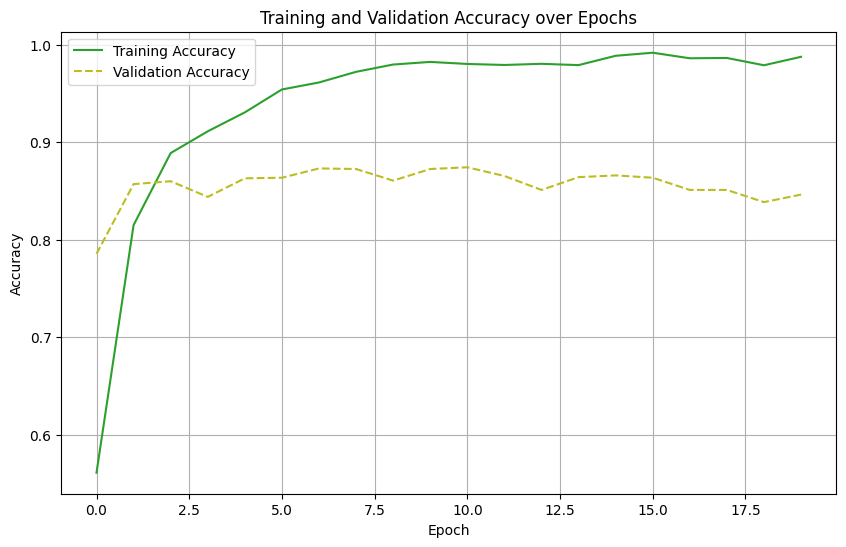

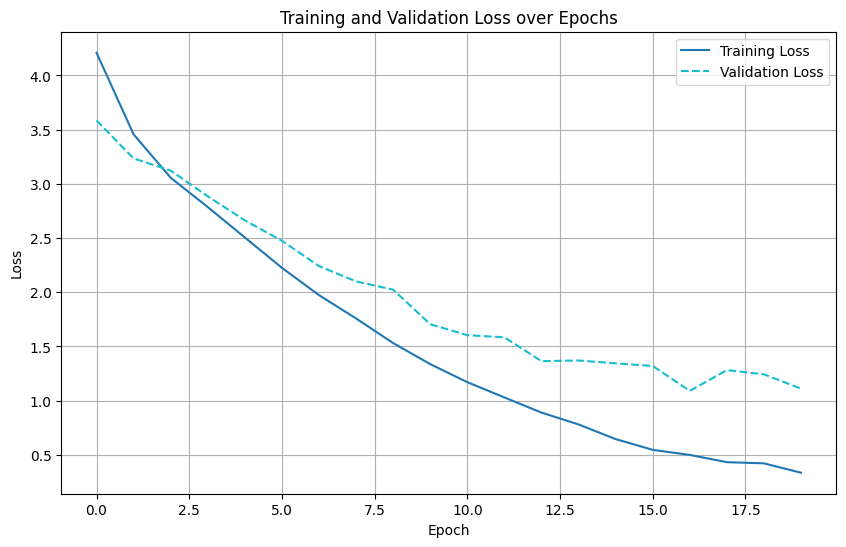

53/53 [==============================] - 5s 57ms/step
Precision is 0.8522734244111099
Recall is 0.8297682442434604
F1: 0.8370527407163392

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       585
           1       0.87      0.65      0.74       203
           2       0.84      0.80      0.82       306
           3       0.75      0.81      0.78       308
           4       0.93      0.98      0.96       277

    accuracy                           0.85      1679
   macro avg       0.85      0.83      0.84      1679
weighted avg       0.85      0.85      0.85      1679



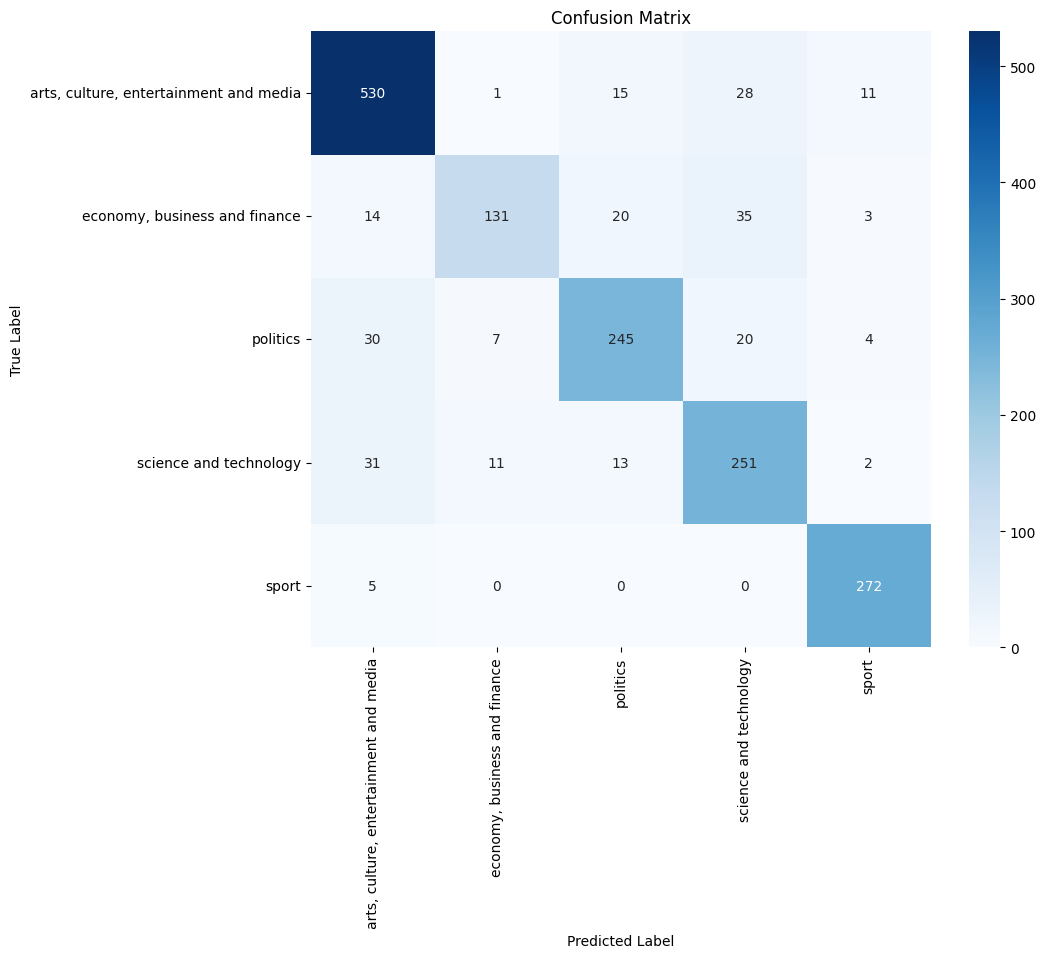

In [18]:
train_dist_bert(X_encoded, df['category_level_1'], 'bjk/model_category_level_1.h5')


In [19]:
# train_dist_bert_kfold(X_encoded, df['category_level_1'], 'bjk/kfold/model_category_level_1')
pnt()


NameError: name 'pnt' is not defined

In [20]:
import os
import numpy as np
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

# ล้างหน่วยความจำ
tf.keras.backend.clear_session()

# ใช้ CPU แทน GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# ใช้ eager execution
tf.config.run_functions_eagerly(True)

# โหลด tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# โหลดโมเดล
model_category_level_1 = tf.keras.models.load_model(
    'model_category_level_1.h5',
    custom_objects={'TFDistilBertModel': TFDistilBertModel}
)

model_category_level_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 80)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 80, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 768)               0         
                                                             

In [21]:
new_texts = [
    "The San Antonio Report’s seventh annual urban ideas festival will be staged in the urban core and will kick off with a discussion on the future of downtown San Antonio, in partnership with the bigcitysmalltown podcast at Texas Public Radio, moderated by Report co-founder Robert Rivard. The breakfast panel on Monday, Oct. 28, will explore one of the hottest topics in the city — the future of San Antonio’s urban core — as City Manager Erik Walsh, Andres Andujar of Hemisfair, Centro San Antonio’s Trish DeBerry, UTSA’s Veronica Salazar and Weston Urban’s David Robinson Jr. discuss development downtown."
]

# กำหนด maxlen ตามที่ใช้ในขณะฝึกโมเดล
maxlen = 80

# ฟังก์ชันเข้ารหัสข้อความใหม่
def regular_encode(texts, tokenizer, maxlen=80):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=maxlen, return_tensors='tf')
    return tokens['input_ids']

# เข้ารหัสข้อความใหม่
X_new_encoded = regular_encode(new_texts, tokenizer, maxlen=maxlen)


In [33]:
def findCategory2(find):
  grouped_counts = df.groupby(['category_level_1']).agg('count')
  unique_categories = grouped_counts.index.tolist()
  if len(unique_categories) >= find:
      category = unique_categories[find]  # Index 26 corresponds to the 27th element
      print(f"Count for category '{category}'")
  else:
      print("There are fewer than ",find," unique categories in 'category_level_1'.")

In [35]:
print("Shape of X_new_encoded:", X_new_encoded.shape)

predictions_level_1 = model_category_level_1.predict(X_new_encoded)
# predictions_level_2 = model_category_level_2.predict(X_new_encoded)

# แสดงผลการทำนาย
predicted_classes_level_1 = np.argmax(predictions_level_1, axis=1)
# predicted_classes_level_2 = np.argmax(predictions_level_2, axis=1)
print(predictions_level_1[0].sum())
print(predictions_level_1[0])
print(np.max(predictions_level_1[0]))
print(findCategory2(np.argmax(predictions_level_1[0])))
predictions_level_1[0][np.argmax(predictions_level_1, axis=1)[0]] = 0
print(np.max(predictions_level_1[0]))
print(predictions_level_1[0][np.argmax(predictions_level_1, axis=1)[0]])
print(findCategory2(np.argmax(predictions_level_1[0])))
print(np.argmax(predictions_level_1, axis=1))

print("Predicted Classes for Category Level 1:", predicted_classes_level_1)
# print("Predicted Classes for Category Level 2:", predicted_classes_level_2)

Shape of X_new_encoded: (1, 80)


c:\Users\Jakkapan\anaconda3\envs\env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 251ms/step
1.641366
[0.9889305  0.14639619 0.18840861 0.15495737 0.16267328]
0.9889305
Count for category 'arts, culture, entertainment and media'
None
0.18840861
0.18840861
Count for category 'politics'
None
[2]
Predicted Classes for Category Level 1: [0]


In [24]:
le = LabelEncoder()

encoded_labels = le.fit_transform(df['category_level_1'])

decoded_labels = le.inverse_transform(encoded_labels)

print("Original labels:", df['category_level_1'])
print("Encoded labels:", encoded_labels)
print("Decoded labels:", decoded_labels)

Original labels: 0       arts, culture, entertainment and media
1       arts, culture, entertainment and media
2       arts, culture, entertainment and media
3       arts, culture, entertainment and media
4       arts, culture, entertainment and media
                         ...                  
8387                    science and technology
8388                    science and technology
8389                    science and technology
8390                    science and technology
8391                    science and technology
Name: category_level_1, Length: 8392, dtype: object
Encoded labels: [0 0 0 ... 3 3 3]
Decoded labels: ['arts, culture, entertainment and media'
 'arts, culture, entertainment and media'
 'arts, culture, entertainment and media' ... 'science and technology'
 'science and technology' 'science and technology']


In [32]:
df.groupby(['category_level_1']).agg('count')

,title,content,text
category_level_1,,,
"arts, culture, entertainment and media",3031,3026,3031
"economy, business and finance",901,901,901
politics,1401,1401,1401
science and technology,1651,1651,1651
sport,1408,1408,1408


In [ ]:
print(findCategory2(0))
print(findCategory2(2))

In [47]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
import tensorflow as tf 
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

In [ ]:
import tensorflow as tf

# ตรวจสอบว่า TensorFlow ใช้ GPU หรือ CPU
print("Num GPUs Available : ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available: ", len(gpus))
else:
    print("No GPUs available.")


In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
print(2662//16)

In [ ]:
import tensorflow as tf
import transformers

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)
print(tf.sysconfig.get_build_info()['cudnn_version'])